<a href="https://colab.research.google.com/github/QWL55/Predicting_Migration_Flow/blob/main/CS224W_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **CS224W - Final Project**

# Setup
First let us check which version of PyTorch you are running

In [1]:
# Install torch geometric
import os
import torch
torch_version = str(torch.__version__)
scatter_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
sparse_src = f"https://pytorch-geometric.com/whl/torch-{torch_version}.html"
!pip install torch-scatter -f $scatter_src
!pip install torch-sparse -f $sparse_src
!pip install torch-geometric
!pip install -q git+https://github.com/snap-stanford/deepsnap.git
!pip install -U -q PyDrive

Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
Looking in links: https://pytorch-geometric.com/whl/torch-2.5.1+cu121.html
  Preparing metadata (setup.py) ... done


# 1) GNN: Link Regression Task

In this section we will build our baseline graph neural network using PyTorch Geometric. Then we will apply it to the task of predicting the volume of migration flow (link regression).

Specifically, we will use GCN as the foundation for the graph neural network ([Kipf et al. (2017)](https://arxiv.org/pdf/1609.02907.pdf)). To do so, we will work with PyG's built-in `GCNConv` layer.

## Setup

In [2]:
import pandas as pd
import numpy as np
import copy
import torch.nn.functional as F
from sklearn.metrics import roc_auc_score
# The PyG built-in GCNConv
import torch_geometric
from torch_geometric.nn import GCNConv
from torch_geometric.utils import negative_sampling
import torch_geometric.transforms as T

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
# change the path to your project folder
os.chdir('/content/drive/MyDrive/Stanford SOC/CS224W/final_projects')

In [5]:
os.listdir()

['CS224W_Colab_2.ipynb',
 'dataset',
 'county_flow.csv',
 'county_node_info.csv',
 'CS224W_Final_Project.ipynb']

## Load and Preprocess the Dataset

In [6]:
from torch_geometric.data import Data

def load_process_data(feat_type):
    # Load the datasets
    county_flow_df = pd.read_csv('county_flow.csv', dtype={"fips_orig": str, "fips_dest": str})
    county_node_df = pd.read_csv('county_node_info.csv', dtype={"GEOID": str})

    # Step 1: Create a mapping from GEOID to index and
    # map fips_orig and fips_dest in county_flow_df to indices
    geo_to_index = {geo_id: idx for idx, geo_id in enumerate(county_node_df['GEOID'])}

    county_flow_df['src'] = county_flow_df['fips_orig'].map(geo_to_index)
    county_flow_df['dst'] = county_flow_df['fips_dest'].map(geo_to_index)

    # Drop any rows with missing mappings (i.e., if a fips code doesn't exist in county_node_df)
    county_flow_df = county_flow_df.dropna(subset=['src', 'dst']).astype({'src': int, 'dst': int})

    # Step 2: Extract the edge list and label
    edge_index_df = county_flow_df[['src', 'dst']]
    edge_index = torch.tensor(edge_index_df.values.T, dtype=torch.long)

    edge_labels = county_flow_df['flow'].values
    edge_labels = torch.tensor(edge_labels, dtype=torch.long)

    # Step 3: Create two versions of county_node_features
    if feat_type == 'full':
        # includes all columns except GEOID
        columns_to_drop = ['GEOID']
    elif feat_type == 'simple':
        # excludes columns with "feature" in their names
        columns_to_drop = ['GEOID'] + [col for col in county_node_df.columns if 'feature' in col.lower()]
    elif feat_type == 'pdfm':
        # include only pdfm features
        columns_to_drop = ['GEOID'] + [col for col in county_node_df.columns if 'feature' not in col.lower()]

    # select relevant features
    county_node_features = county_node_df.drop(columns=columns_to_drop, errors='ignore').values
    county_node_features = torch.tensor(county_node_features, dtype=torch.float)

    # Create PyG Data object
    data = Data(x=county_node_features, edge_index=edge_index, y=edge_labels,
                edge_label=edge_labels)
    data.num_node_features = county_node_features.shape[1]
    data.num_classes = 1

    return data

In [61]:
data_full = load_process_data('full')
data_simple = load_process_data('simple')
data_pdfm = load_process_data('pdfm')

print("Data with full features:")
print(data_full)
print("\nData with simple features:")
print(data_simple)
print("\nData with pdfm features:")
print(data_pdfm)

Data with full features:
Data(x=[3116, 339], edge_index=[2, 107568], y=[107568], edge_label=[107568], num_node_features=339, num_classes=1)

Data with simple features:
Data(x=[3116, 9], edge_index=[2, 107568], y=[107568], edge_label=[107568], num_node_features=9, num_classes=1)

Data with pdfm features:
Data(x=[3116, 330], edge_index=[2, 107568], y=[107568], edge_label=[107568], num_node_features=330, num_classes=1)


In [8]:
# Data splitting
transform = T.Compose([T.ToSparseTensor(),
                       T.RandomLinkSplit(is_undirected=False)])

train_data, val_data, test_data = transform(data_full)
train_data, val_data, test_data = transform(data_simple)
print(train_data)

Data(x=[3116, 9], y=[75299], num_node_features=9, num_classes=1, adj_t=[3116, 3116, nnz=107568], edge_index=[2, 75299], edge_label=[150598], edge_label_index=[2, 150598])


In [9]:
train_data.edge_label.shape
val_data.edge_label.shape

torch.Size([21512])

# Model Building

In [56]:
import torch
import torch_scatter
import torch.nn as nn
import torch.nn.functional as F

import torch_geometric.nn as pyg_nn
import torch_geometric.utils as pyg_utils

from torch import Tensor
from typing import Union, Tuple, Optional
from torch_geometric.typing import (OptPairTensor, Adj, Size, NoneType,
                                    OptTensor)

from torch.nn import Parameter, Linear
from torch_sparse import SparseTensor, set_diag
from torch_geometric.nn.conv import MessagePassing
from torch_geometric.utils import remove_self_loops, add_self_loops, softmax

class GNNStack(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, args, emb=False):
        super(GNNStack, self).__init__()
        conv_model = self.build_conv_model(args.model_type)
        self.convs = nn.ModuleList()
        self.bns = nn.ModuleList()
        self.convs.append(conv_model(input_dim, hidden_dim))
        assert (args.num_layers >= 1), 'Number of layers is not >=1'
        for l in range(args.num_layers-1):
            self.convs.append(conv_model(args.heads * hidden_dim, hidden_dim))

        # post-message-passing
        # times 2 because we concatenate node embedding
        self.link_regressor = nn.Sequential(
            nn.Linear(2 * args.heads *hidden_dim, hidden_dim),
            nn.Dropout(args.dropout),
            nn.Linear(hidden_dim, output_dim))

        self.dropout = args.dropout

        for _ in range(args.num_layers):
            self.bns.append(torch.nn.BatchNorm1d(args.heads *hidden_dim))

        self.num_layers = args.num_layers

        self.emb = emb
        self.reset_parameters()

    def reset_parameters(self):
        # Reset parameters of convolutional layers
        for conv in self.convs:
            if hasattr(conv, 'reset_parameters'):
                conv.reset_parameters()
        # Reset parameters of link_regressor layers
        for layer in self.link_regressor:
            if isinstance(layer, nn.Linear):
                layer.reset_parameters()

        for bn in self.bns:
            bn.reset_parameters()


    def build_conv_model(self, model_type):
        if model_type == 'GraphSage':
            return GraphSage
        elif model_type == 'GCN':
            return GCNConv
        elif model_type == 'GAT':
            return GAT

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        out = x

        for i in range(self.num_layers):
            out = self.convs[i](out, edge_index)
            out = self.bns[i](out)
            out = F.relu(out)
            output = F.dropout(out, p=self.dropout,training=self.training)

        if self.emb == True:
            return out

        return self.predict_edges(out, edge_index)

    def predict_edges(self, node_features, edge_index):
        # Extract source and destination node embeddings
        node_features_src = node_features[edge_index[0]]  # Source nodes
        node_features_dst = node_features[edge_index[1]]  # Destination nodes

        # Combine embeddings (e.g., using dot product or concatenation)
        edge_features = torch.cat([node_features_src, node_features_dst], dim=-1)

        # Predict edge values (continuous outputs)
        edge_predictions = self.link_regressor(edge_features)

        return edge_predictions

    def loss(self, pred, label):
        return F.l1_loss(pred, label)

## GraphSage


In [11]:
class GraphSage(MessagePassing):

    def __init__(self, in_channels, out_channels, normalize = True,
                 bias = False, aggr="mean", **kwargs):
        super(GraphSage, self).__init__(**kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.normalize = normalize
        self.aggr = aggr
        ############################################################################
        # TODO: Your code here!
        # Define the (PyTorch) layers needed for the message and update functions below.
        # self.lin_l is the linear transformation that you apply to embedding
        #            for central node.
        # self.lin_r is the linear transformation that you apply to aggregated
        #            message from neighbors.
        # Don't forget the bias as part of the linear layers!
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.lin_l = nn.Linear(in_channels, out_channels, bias=bias)
        self.lin_r = nn.Linear(in_channels, out_channels, bias=bias)
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        self.lin_l.reset_parameters()
        self.lin_r.reset_parameters()

    def forward(self, x, edge_index, size = None):
        """"""

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any post-processing (our update rule).
        # 1. Call the propagate function to conduct the message passing.
        #    1.1 See the description of propagate above or the following link for more information:
        #        https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        #    1.2 We will only use the representation for neighbor nodes (x_j), so by default
        #        we pass the same representation for central and neighbor nodes as x=(x, x).
        # 2. Update our node embedding with skip connection from the previous layer.
        # 3. If normalize is set, do L-2 normalization (defined in
        #    torch.nn.functional)
        out = self.propagate(edge_index, x=(x,x), size=size)
        out = self.lin_l(x) + self.lin_r(out)
        if self.normalize:
            out = F.normalize(out, p=2, dim=-1)

        return out

    def message(self, x_j):

        ############################################################################
        # TODO: Your code here!
        # Implement your message function here.
        # Hint: Look at the formulation of the mean aggregation function, focusing on
        # what message each neighboring node passes.
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = x_j
        ############################################################################

        return out

    def aggregate(self, inputs, index, dim_size = None):
        # The axis along which to index number of nodes.
        node_dim = self.node_dim

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter:
        # https://pytorch-scatter.readthedocs.io/en/latest/functions/scatter.html#torch_scatter.scatter
        #
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, dim=node_dim, reduce=self.aggr)

        ############################################################################

        return out

## GAT


In [12]:
class GAT(MessagePassing):

    def __init__(self, in_channels, out_channels, heads = 2,
                 negative_slope = 0.2, dropout = 0., **kwargs):
        super(GAT, self).__init__(node_dim=0, **kwargs)

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.heads = heads
        self.negative_slope = negative_slope
        self.dropout = dropout

        ############################################################################
        # TODO: Your code here!
        # Define the layers needed for the message functions below.
        # self.lin_l is the linear transformation that you apply to embeddings
        # BEFORE message passing.
        #
        # Pay attention to dimensions of the linear layers, since we're using
        # multi-head attention.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        self.lin_l = nn.Linear(in_channels, heads * out_channels, bias=False)
        ############################################################################

        self.lin_r = self.lin_l

        ############################################################################
        # TODO: Your code here!
        # Define the attention parameters \overrightarrow{a_l/r}^T in the above intro.
        # You have to deal with multi-head scenarios.
        # Use nn.Parameter instead of nn.Linear
        # Our implementation is ~2 lines, but don't worry if you deviate from this.
        self.att_l = nn.Parameter(torch.Tensor(1, heads, out_channels))
        self.att_r = nn.Parameter(torch.Tensor(1, heads, out_channels))
        ############################################################################

        self.reset_parameters()

    def reset_parameters(self):
        nn.init.xavier_uniform_(self.lin_l.weight)
        nn.init.xavier_uniform_(self.lin_r.weight)
        nn.init.xavier_uniform_(self.att_l)
        nn.init.xavier_uniform_(self.att_r)

    def forward(self, x, edge_index, size = None):

        H, C = self.heads, self.out_channels

        ############################################################################
        # TODO: Your code here!
        # Implement message passing, as well as any pre- and post-processing (our update rule).
        # 1. First apply linear transformation to node embeddings, and split that
        #    into multiple heads. We use the same representations for source and
        #    target nodes, but apply different linear weights (W_l and W_r)
        # 2. Calculate alpha vectors for central nodes (alpha_l) and neighbor nodes (alpha_r).
        # 3. Call propagate function to conduct the message passing.
        #    3.1 Remember to pass alpha = (alpha_l, alpha_r) as a parameter.
        #    3.2 See there for more information: https://pytorch-geometric.readthedocs.io/en/latest/notes/create_gnn.html
        # 4. Transform the output back to the shape of [N, H * C].
        # Our implementation is ~5 lines, but don't worry if you deviate from this.
        x_l, x_r = self.lin_l(x).view(-1, H, C), self.lin_r(x).view(-1, H, C)
        alpha_l = (x_l * self.att_l).sum(dim=-1)
        alpha_r = (x_r * self.att_r).sum(dim=-1)

        out = self.propagate(edge_index, x=(x_l,x_r), alpha=(alpha_l, alpha_r), size=size)
        out = out.view(-1, H * C)
        ############################################################################

        return out


    def message(self, x_j, alpha_j, alpha_i, index, ptr, size_i):

        ############################################################################
        # TODO: Your code here!
        # Implement your message function. Putting the attention in message
        # instead of in update is a little tricky.
        # 1. Calculate the final attention weights using alpha_i and alpha_j,
        #    and apply leaky Relu.
        # 2. Calculate softmax over the neighbor nodes for all the nodes. Use
        #    torch_geometric.utils.softmax instead of the one in Pytorch.
        # 3. Apply dropout to attention weights (alpha).
        # 4. Multiply embeddings and attention weights. As a sanity check, the output
        #    should be of shape [E, H, C].
        # 5. ptr (LongTensor, optional): If given, computes the softmax based on
        #    sorted inputs in CSR representation. You can simply pass it to softmax.
        # 6. size_i: corresponds to the num_nodes variable input to the torch.geometric.softmax method
        # Our implementation is ~4-5 lines, but don't worry if you deviate from this.
        alpha = alpha_i + alpha_j
        out = F.leaky_relu(alpha, self.negative_slope)
        out = torch_geometric.utils.softmax(out, index, ptr, size_i)
        out = F.dropout(out, p=self.dropout, training=self.training)
        out = x_j * out.unsqueeze(-1)
        ############################################################################

        return out


    def aggregate(self, inputs, index, dim_size = None):

        ############################################################################
        # TODO: Your code here!
        # Implement your aggregate function here.
        # See here as how to use torch_scatter.scatter: https://pytorch-scatter.readthedocs.io/en/latest/_modules/torch_scatter/scatter.html
        # Pay attention to "reduce" parameter is different from that in GraphSage.
        # Our implementation is ~1 lines, but don't worry if you deviate from this.
        out = torch_scatter.scatter(inputs, index, dim=0, dim_size=dim_size, reduce='sum')
        ############################################################################

        return out

## Optimizer

In [13]:
import torch.optim as optim

def build_optimizer(args, params):
    weight_decay = args.weight_decay
    filter_fn = filter(lambda p : p.requires_grad, params)
    if args.opt == 'adam':
        optimizer = optim.Adam(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'sgd':
        optimizer = optim.SGD(filter_fn, lr=args.lr, momentum=0.95, weight_decay=weight_decay)
    elif args.opt == 'rmsprop':
        optimizer = optim.RMSprop(filter_fn, lr=args.lr, weight_decay=weight_decay)
    elif args.opt == 'adagrad':
        optimizer = optim.Adagrad(filter_fn, lr=args.lr, weight_decay=weight_decay)
    if args.opt_scheduler == 'none':
        return None, optimizer
    elif args.opt_scheduler == 'step':
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=args.opt_decay_step, gamma=args.opt_decay_rate)
    elif args.opt_scheduler == 'cos':
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=args.opt_restart)
    return scheduler, optimizer

# Model Training and Evaluation

In [70]:
pip install torcheval

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.2/179.2 kB 4.0 MB/s eta 0:00:00


In [77]:
from torch_geometric.data import DataLoader
from tqdm import trange
import matplotlib.pyplot as plt
from torcheval.metrics.functional import r2_score

def train(args):

    transform = T.Compose([T.ToSparseTensor(),
                       T.RandomLinkSplit(is_undirected=False)])
    dataset = args.dataset
    train_data, val_data, test_data = transform(dataset)

    #print("Node task. test set size:", np.sum(dataset[0]['test_mask'].numpy()))
    #test_loader = loader = DataLoader(dataset, batch_size=args.batch_size, shuffle=False)

    # build model
    model = GNNStack(dataset.num_node_features, args.hidden_dim, dataset.num_classes,
                            args)
    scheduler, opt = build_optimizer(args, model.parameters())

    # train
    train_losses = []
    val_losses = []
    test_losses = []
    train_r2_scores = []
    val_r2_scores = []
    test_r2_scores = []

    best_val_loss = float('inf')
    best_model = None

    for epoch in trange(args.epochs, desc="Training", unit="Epochs"):
        model.train()
        #for batch in loader:
        opt.zero_grad()
        pred = model(train_data).squeeze(-1)
        label = train_data.y
        #pred = pred[batch.train_mask]
        #label = label[batch.train_mask]
        loss = model.loss(pred, label)
        loss.backward()
        opt.step()

        train_losses.append(loss.item())
        train_r2 = r2_score(pred, label)
        train_r2_scores.append(train_r2.item())

        val_loss, val_r2 = test(val_data, model)
        val_losses.append(val_loss)
        val_r2_scores.append(val_r2.item())

        print(
            f"Epoch {epoch + 1}: Training Loss {round(loss.item(), 5)}, "
            f"Training R2 {round(train_r2.item(), 5)}",
            f"Validation Loss {round(val_loss, 5)}",
            f"Validation R2 {round(val_r2.item(), 5)}"
        )

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model)

        test_loss, test_r2 = test(test_data, model)
        test_losses.append(test_loss)
        test_r2_scores.append(test_r2.item())

    return train_losses, val_losses, test_losses, best_model, test_data


def test(data, test_model, save_model_preds=False, model_type=None,
         feature_type=None):
    test_model.eval()

    #correct = 0
    # Note that Cora is only one graph!
    with torch.no_grad():
        # max(dim=1) returns values, indices tuple; only need indices
        pred = test_model(data).squeeze(-1)
        label = data.y
        loss = test_model.loss(pred, label)
        r2 = r2_score(pred, label)
        #mask = data.val_mask if is_validation else data.test_mask
        # node classification: only evaluate on nodes in test set
        #pred = pred[mask]
        #label = label[mask]

        if save_model_preds:
            print ("Saving Model Predictions for Model Type", model_type)

            data = {}
            data['pred'] = pred.view(-1).cpu().detach().numpy()
            data['label'] = label.view(-1).cpu().detach().numpy()

            df = pd.DataFrame(data=data)
            # Save locally as csv
            df.to_csv('flow_' + model_type + "_" + feature_type +
                      '.csv', sep=',', index=False)
            # save model object as a pickle

        #correct += pred.eq(label).sum().item()

    #total = 0
    #for data in loader.dataset:
    #total += torch.sum(data.val_mask if is_validation else data.test_mask).item()

    return loss.item(), r2

class objectview(object):
    def __init__(self, d):
        self.__dict__ = d


In [74]:
def run_pipeline(arg):

    args = objectview(arg)
    train_losses, val_losses, test_losses, best_model, test_data = train(args)

    #print("Maximum test set accuracy: {0}".format(max(test_accs)))
    print("Minimum validation loss: {0}".format(min(val_losses)))
    print("Minimum test loss: {0}".format(min(test_losses)))
    # Run test for our best model to save the predictions!
    test(test_data, best_model, save_model_preds=True,
         model_type=args.model_type, feature_type=args.feature_type)

    plt.title("Migration Flow Prediction L1 Loss")
    plt.plot(train_losses, label="training loss" + " - " + args.model_type)
    plt.plot(val_losses, label="validation loss" + " - " + args.model_type)
    plt.plot(test_losses, label="test loss" + " - " + args.model_type)
    plt.legend()
    plt.show()

## Running models

In [75]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args = {
    'device': device,
    'num_layers': 3,
    'hidden_dim': 64,
    "out_dim": 1,
    'dropout': 0.5,
    'lr': 0.01,
    'epochs': 100,
    'model_type': "GCN",
    'batch_size': 32,
    'heads': 1,
    'opt': 'adam',
    'opt_scheduler': 'none',
    'opt_restart': 0,
    'weight_decay': 5e-3,
    'feature_type': 'full',
    'dataset': data_full
}

args_GraphSage = args.copy()
args_GraphSage["model_type"] = "GraphSage"

args_GAT = args.copy()
args_GAT["model_type"] = "GAT"
args_GAT["heads"] = 2

Training:   0%|          | 0/100 [00:00<?, ?Epochs/s]

Epoch 1: Training Loss 154.27269, Training R2 -0.07302 Validation Loss 153.77066 Validation R2 -0.0725


Training:   1%|          | 1/100 [00:01<01:41,  1.03s/Epochs]

Epoch 2: Training Loss 151.86902, Training R2 -0.07061 Validation Loss 153.34454 Validation R2 -0.07208


Training:   2%|▏         | 2/100 [00:02<01:44,  1.07s/Epochs]

Epoch 3: Training Loss 146.87949, Training R2 -0.06517 Validation Loss 152.9232 Validation R2 -0.07163


Training:   3%|▎         | 3/100 [00:03<01:52,  1.16s/Epochs]

Epoch 4: Training Loss 139.02621, Training R2 -0.05666 Validation Loss 152.5677 Validation R2 -0.07125


Training:   4%|▍         | 4/100 [00:04<02:02,  1.27s/Epochs]

Epoch 5: Training Loss 129.38895, Training R2 -0.04476 Validation Loss 152.21307 Validation R2 -0.07088


Training:   5%|▌         | 5/100 [00:06<02:09,  1.36s/Epochs]

Epoch 6: Training Loss 123.01289, Training R2 -0.03048 Validation Loss 151.50714 Validation R2 -0.07008


Training:   6%|▌         | 6/100 [00:07<02:05,  1.34s/Epochs]

Epoch 7: Training Loss 120.08228, Training R2 -0.0204 Validation Loss 149.67894 Validation R2 -0.06806


Training:   7%|▋         | 7/100 [00:08<01:56,  1.25s/Epochs]

Epoch 8: Training Loss 118.23846, Training R2 -0.01914 Validation Loss 145.69083 Validation R2 -0.06432


Training:   8%|▊         | 8/100 [00:09<01:50,  1.21s/Epochs]

Epoch 9: Training Loss 117.17096, Training R2 -0.02573 Validation Loss 140.99507 Validation R2 -0.06038


Training:   9%|▉         | 9/100 [00:10<01:46,  1.17s/Epochs]

Epoch 10: Training Loss 116.4174, Training R2 -0.02449 Validation Loss 137.28931 Validation R2 -0.05738


Training:  10%|█         | 10/100 [00:12<01:43,  1.15s/Epochs]

Epoch 11: Training Loss 115.93819, Training R2 -0.0208 Validation Loss 134.55278 Validation R2 -0.05522


Training:  11%|█         | 11/100 [00:13<01:40,  1.13s/Epochs]

Epoch 12: Training Loss 115.74918, Training R2 -0.0182 Validation Loss 132.66148 Validation R2 -0.05376


Training:  12%|█▏        | 12/100 [00:14<01:38,  1.12s/Epochs]

Epoch 13: Training Loss 115.63985, Training R2 -0.01913 Validation Loss 131.36037 Validation R2 -0.05276


Training:  13%|█▎        | 13/100 [00:15<01:36,  1.11s/Epochs]

Epoch 14: Training Loss 115.6037, Training R2 -0.02121 Validation Loss 130.55223 Validation R2 -0.05215


Training:  14%|█▍        | 14/100 [00:16<01:35,  1.11s/Epochs]

Epoch 15: Training Loss 115.6626, Training R2 -0.02221 Validation Loss 130.09659 Validation R2 -0.0518


Training:  15%|█▌        | 15/100 [00:17<01:37,  1.15s/Epochs]

Epoch 16: Training Loss 115.70473, Training R2 -0.02216 Validation Loss 129.83234 Validation R2 -0.05158


Training:  16%|█▌        | 16/100 [00:19<01:44,  1.24s/Epochs]

Epoch 17: Training Loss 115.73466, Training R2 -0.02077 Validation Loss 129.69806 Validation R2 -0.05146


Training:  17%|█▋        | 17/100 [00:20<01:48,  1.31s/Epochs]

Epoch 18: Training Loss 115.69785, Training R2 -0.01925 Validation Loss 129.64238 Validation R2 -0.05141


Training:  18%|█▊        | 18/100 [00:21<01:43,  1.26s/Epochs]

Epoch 19: Training Loss 115.71612, Training R2 -0.01846 Validation Loss 129.62483 Validation R2 -0.05138


Training:  19%|█▉        | 19/100 [00:22<01:35,  1.18s/Epochs]

Epoch 20: Training Loss 115.60188, Training R2 -0.0196 Validation Loss 129.62415 Validation R2 -0.05137


Training:  20%|██        | 20/100 [00:23<01:32,  1.16s/Epochs]

Epoch 21: Training Loss 115.47437, Training R2 -0.02135 Validation Loss 129.58669 Validation R2 -0.05133


Training:  21%|██        | 21/100 [00:25<01:36,  1.22s/Epochs]

Epoch 22: Training Loss 115.44753, Training R2 -0.02174 Validation Loss 129.50998 Validation R2 -0.05124


Training:  22%|██▏       | 22/100 [00:26<01:30,  1.16s/Epochs]

Epoch 23: Training Loss 115.38972, Training R2 -0.02107 Validation Loss 129.41982 Validation R2 -0.05112


Training:  23%|██▎       | 23/100 [00:27<01:26,  1.12s/Epochs]

Epoch 24: Training Loss 115.3184, Training R2 -0.02017 Validation Loss 129.33725 Validation R2 -0.05102


Training:  24%|██▍       | 24/100 [00:28<01:25,  1.13s/Epochs]

Epoch 25: Training Loss 115.26079, Training R2 -0.01906 Validation Loss 129.28467 Validation R2 -0.05094


Training:  25%|██▌       | 25/100 [00:29<01:23,  1.12s/Epochs]

Epoch 26: Training Loss 115.24294, Training R2 -0.01894 Validation Loss 129.26729 Validation R2 -0.05091


Training:  26%|██▌       | 26/100 [00:30<01:22,  1.12s/Epochs]

Epoch 27: Training Loss 115.28133, Training R2 -0.01974 Validation Loss 129.25404 Validation R2 -0.05088


Training:  27%|██▋       | 27/100 [00:31<01:25,  1.18s/Epochs]

Epoch 28: Training Loss 115.2791, Training R2 -0.02075 Validation Loss 129.23137 Validation R2 -0.05083


Training:  28%|██▊       | 28/100 [00:33<01:31,  1.27s/Epochs]

Epoch 29: Training Loss 115.18774, Training R2 -0.0215 Validation Loss 129.22252 Validation R2 -0.05078


Training:  29%|██▉       | 29/100 [00:34<01:35,  1.34s/Epochs]

Epoch 30: Training Loss 115.15984, Training R2 -0.02097 Validation Loss 129.18886 Validation R2 -0.05069


Training:  30%|███       | 30/100 [00:35<01:27,  1.25s/Epochs]

Epoch 31: Training Loss 115.17109, Training R2 -0.02009 Validation Loss 129.09303 Validation R2 -0.05054


Training:  31%|███       | 31/100 [00:36<01:21,  1.18s/Epochs]

Epoch 32: Training Loss 115.19109, Training R2 -0.01958 Validation Loss 128.93799 Validation R2 -0.05036


Training:  32%|███▏      | 32/100 [00:38<01:18,  1.16s/Epochs]

Epoch 33: Training Loss 115.11797, Training R2 -0.01916 Validation Loss 128.72285 Validation R2 -0.05014


Training:  33%|███▎      | 33/100 [00:39<01:16,  1.14s/Epochs]

Epoch 34: Training Loss 115.11491, Training R2 -0.01985 Validation Loss 128.4516 Validation R2 -0.04989


Training:  34%|███▍      | 34/100 [00:40<01:14,  1.13s/Epochs]

Epoch 35: Training Loss 115.12862, Training R2 -0.02078 Validation Loss 128.12677 Validation R2 -0.04957


Training:  35%|███▌      | 35/100 [00:41<01:13,  1.13s/Epochs]

Epoch 36: Training Loss 115.04768, Training R2 -0.02083 Validation Loss 127.69405 Validation R2 -0.0491


Training:  36%|███▌      | 36/100 [00:42<01:12,  1.13s/Epochs]

Epoch 37: Training Loss 115.12316, Training R2 -0.02062 Validation Loss 127.21437 Validation R2 -0.04857


Training:  37%|███▋      | 37/100 [00:43<01:11,  1.13s/Epochs]

Epoch 38: Training Loss 115.06749, Training R2 -0.0199 Validation Loss 126.71794 Validation R2 -0.04802


Training:  38%|███▊      | 38/100 [00:44<01:09,  1.13s/Epochs]

Epoch 39: Training Loss 115.12096, Training R2 -0.01957 Validation Loss 126.22997 Validation R2 -0.04749


Training:  39%|███▉      | 39/100 [00:46<01:15,  1.25s/Epochs]

Epoch 40: Training Loss 115.07683, Training R2 -0.01942 Validation Loss 125.75024 Validation R2 -0.04698


Training:  40%|████      | 40/100 [00:47<01:19,  1.32s/Epochs]

Epoch 41: Training Loss 115.03349, Training R2 -0.02029 Validation Loss 125.27206 Validation R2 -0.04645


Training:  41%|████      | 41/100 [00:49<01:21,  1.37s/Epochs]

Epoch 42: Training Loss 115.05546, Training R2 -0.02054 Validation Loss 124.74787 Validation R2 -0.04581


Training:  42%|████▏     | 42/100 [00:50<01:15,  1.30s/Epochs]

Epoch 43: Training Loss 115.02057, Training R2 -0.02044 Validation Loss 124.17535 Validation R2 -0.04506


Training:  43%|████▎     | 43/100 [00:51<01:10,  1.24s/Epochs]

Epoch 44: Training Loss 115.11138, Training R2 -0.01983 Validation Loss 123.57008 Validation R2 -0.04426


Training:  44%|████▍     | 44/100 [00:52<01:07,  1.21s/Epochs]

Epoch 45: Training Loss 115.00351, Training R2 -0.01941 Validation Loss 122.98028 Validation R2 -0.04348


Training:  45%|████▌     | 45/100 [00:53<01:04,  1.17s/Epochs]

Epoch 46: Training Loss 115.064, Training R2 -0.01932 Validation Loss 122.35735 Validation R2 -0.04267


Training:  46%|████▌     | 46/100 [00:55<01:07,  1.25s/Epochs]

Epoch 47: Training Loss 115.04477, Training R2 -0.02004 Validation Loss 121.7139 Validation R2 -0.04179


Training:  47%|████▋     | 47/100 [00:56<01:04,  1.22s/Epochs]

Epoch 48: Training Loss 115.01355, Training R2 -0.02019 Validation Loss 121.09138 Validation R2 -0.04086


Training:  48%|████▊     | 48/100 [00:57<01:01,  1.19s/Epochs]

Epoch 49: Training Loss 115.04755, Training R2 -0.02026 Validation Loss 120.55753 Validation R2 -0.03998


Training:  49%|████▉     | 49/100 [00:58<00:59,  1.17s/Epochs]

Epoch 50: Training Loss 115.05676, Training R2 -0.01976 Validation Loss 120.08873 Validation R2 -0.03918


Training:  50%|█████     | 50/100 [00:59<00:59,  1.20s/Epochs]

Epoch 51: Training Loss 114.97459, Training R2 -0.01954 Validation Loss 119.69054 Validation R2 -0.03846


Training:  51%|█████     | 51/100 [01:01<01:03,  1.29s/Epochs]

Epoch 52: Training Loss 115.05749, Training R2 -0.01947 Validation Loss 119.31978 Validation R2 -0.03774


Training:  52%|█████▏    | 52/100 [01:02<01:04,  1.35s/Epochs]

Epoch 53: Training Loss 115.04285, Training R2 -0.01925 Validation Loss 118.91207 Validation R2 -0.03694


Training:  53%|█████▎    | 53/100 [01:04<01:03,  1.36s/Epochs]

Epoch 54: Training Loss 114.97117, Training R2 -0.01966 Validation Loss 118.47143 Validation R2 -0.03605


Training:  54%|█████▍    | 54/100 [01:05<00:59,  1.29s/Epochs]

Epoch 55: Training Loss 114.99117, Training R2 -0.01984 Validation Loss 118.05011 Validation R2 -0.03516


Training:  55%|█████▌    | 55/100 [01:06<00:55,  1.24s/Epochs]

Epoch 56: Training Loss 115.0118, Training R2 -0.0197 Validation Loss 117.66876 Validation R2 -0.03434


Training:  56%|█████▌    | 56/100 [01:07<00:53,  1.21s/Epochs]

Epoch 57: Training Loss 114.97389, Training R2 -0.0199 Validation Loss 117.33781 Validation R2 -0.03354


Training:  57%|█████▋    | 57/100 [01:08<00:50,  1.18s/Epochs]

Epoch 58: Training Loss 115.01611, Training R2 -0.01992 Validation Loss 117.00708 Validation R2 -0.03267


Training:  58%|█████▊    | 58/100 [01:09<00:48,  1.16s/Epochs]

Epoch 59: Training Loss 114.98219, Training R2 -0.01953 Validation Loss 116.67328 Validation R2 -0.03178


Training:  59%|█████▉    | 59/100 [01:10<00:46,  1.15s/Epochs]

Epoch 60: Training Loss 114.99352, Training R2 -0.0196 Validation Loss 116.35562 Validation R2 -0.0309


Training:  60%|██████    | 60/100 [01:12<00:45,  1.13s/Epochs]

Epoch 61: Training Loss 115.00292, Training R2 -0.02012 Validation Loss 116.07464 Validation R2 -0.03006


Training:  61%|██████    | 61/100 [01:13<00:44,  1.13s/Epochs]

Epoch 62: Training Loss 115.0062, Training R2 -0.02017 Validation Loss 115.85519 Validation R2 -0.02931


Training:  62%|██████▏   | 62/100 [01:14<00:44,  1.18s/Epochs]

Epoch 63: Training Loss 115.01406, Training R2 -0.02038 Validation Loss 115.70009 Validation R2 -0.02868


Training:  63%|██████▎   | 63/100 [01:15<00:47,  1.28s/Epochs]

Epoch 64: Training Loss 115.00414, Training R2 -0.01972 Validation Loss 115.58182 Validation R2 -0.02813


Training:  64%|██████▍   | 64/100 [01:17<00:48,  1.35s/Epochs]

Epoch 65: Training Loss 114.98125, Training R2 -0.01949 Validation Loss 115.49011 Validation R2 -0.0277


Training:  65%|██████▌   | 65/100 [01:18<00:46,  1.33s/Epochs]

Epoch 66: Training Loss 114.97951, Training R2 -0.0195 Validation Loss 115.39768 Validation R2 -0.0273


Training:  66%|██████▌   | 66/100 [01:19<00:43,  1.27s/Epochs]

Epoch 67: Training Loss 114.9889, Training R2 -0.01967 Validation Loss 115.29097 Validation R2 -0.02681


Training:  67%|██████▋   | 67/100 [01:21<00:40,  1.23s/Epochs]

Epoch 68: Training Loss 115.0296, Training R2 -0.01977 Validation Loss 115.17774 Validation R2 -0.02624


Training:  68%|██████▊   | 68/100 [01:22<00:38,  1.20s/Epochs]

Epoch 69: Training Loss 114.96145, Training R2 -0.01966 Validation Loss 115.09392 Validation R2 -0.02581


Training:  69%|██████▉   | 69/100 [01:23<00:36,  1.17s/Epochs]

Epoch 70: Training Loss 114.98169, Training R2 -0.01963 Validation Loss 115.04208 Validation R2 -0.02557


Training:  70%|███████   | 70/100 [01:24<00:34,  1.15s/Epochs]

Epoch 71: Training Loss 115.00486, Training R2 -0.01992 Validation Loss 114.97459 Validation R2 -0.02518


Training:  71%|███████   | 71/100 [01:25<00:33,  1.14s/Epochs]

Epoch 72: Training Loss 115.00142, Training R2 -0.01987 Validation Loss 114.87696 Validation R2 -0.02446


Training:  72%|███████▏  | 72/100 [01:26<00:31,  1.14s/Epochs]

Epoch 73: Training Loss 114.98026, Training R2 -0.01924 Validation Loss 114.79922 Validation R2 -0.02385


Training:  73%|███████▎  | 73/100 [01:27<00:30,  1.13s/Epochs]

Epoch 74: Training Loss 115.00912, Training R2 -0.01933 Validation Loss 114.77545 Validation R2 -0.02373


Training:  74%|███████▍  | 74/100 [01:29<00:31,  1.21s/Epochs]

Epoch 75: Training Loss 114.99809, Training R2 -0.02018 Validation Loss 114.73048 Validation R2 -0.02327


Training:  75%|███████▌  | 75/100 [01:30<00:32,  1.29s/Epochs]

Epoch 76: Training Loss 114.95381, Training R2 -0.01948 Validation Loss 114.71533 Validation R2 -0.02305


Training:  76%|███████▌  | 76/100 [01:32<00:32,  1.36s/Epochs]

Epoch 77: Training Loss 114.94216, Training R2 -0.01946 Validation Loss 114.72752 Validation R2 -0.02314


Training:  77%|███████▋  | 77/100 [01:33<00:30,  1.32s/Epochs]

Epoch 78: Training Loss 114.9934, Training R2 -0.01948 Validation Loss 114.73009 Validation R2 -0.02318


Training:  78%|███████▊  | 78/100 [01:34<00:27,  1.26s/Epochs]

Epoch 79: Training Loss 114.98596, Training R2 -0.01991 Validation Loss 114.67795 Validation R2 -0.02256


Training:  79%|███████▉  | 79/100 [01:35<00:25,  1.22s/Epochs]

Epoch 80: Training Loss 114.94648, Training R2 -0.01955 Validation Loss 114.6378 Validation R2 -0.02225


Training:  80%|████████  | 80/100 [01:36<00:23,  1.19s/Epochs]

Epoch 81: Training Loss 114.93491, Training R2 -0.01974 Validation Loss 114.59325 Validation R2 -0.02175


Training:  81%|████████  | 81/100 [01:37<00:22,  1.17s/Epochs]

Epoch 82: Training Loss 114.97069, Training R2 -0.02004 Validation Loss 114.56714 Validation R2 -0.0213


Training:  82%|████████▏ | 82/100 [01:38<00:20,  1.15s/Epochs]

Epoch 83: Training Loss 114.91239, Training R2 -0.01955 Validation Loss 114.55355 Validation R2 -0.02106


Training:  83%|████████▎ | 83/100 [01:40<00:19,  1.14s/Epochs]

Epoch 84: Training Loss 114.96896, Training R2 -0.01966 Validation Loss 114.53921 Validation R2 -0.02072


Training:  84%|████████▍ | 84/100 [01:41<00:17,  1.11s/Epochs]

Epoch 85: Training Loss 114.92308, Training R2 -0.01896 Validation Loss 114.54535 Validation R2 -0.02105


Training:  85%|████████▌ | 85/100 [01:42<00:16,  1.08s/Epochs]

Epoch 86: Training Loss 114.97093, Training R2 -0.02004 Validation Loss 114.53008 Validation R2 -0.02049


Training:  86%|████████▌ | 86/100 [01:43<00:16,  1.16s/Epochs]

Epoch 87: Training Loss 114.98105, Training R2 -0.01936 Validation Loss 114.52773 Validation R2 -0.02042


Training:  87%|████████▋ | 87/100 [01:44<00:16,  1.25s/Epochs]

Epoch 88: Training Loss 114.93988, Training R2 -0.01939 Validation Loss 114.53187 Validation R2 -0.02044


Training:  88%|████████▊ | 88/100 [01:46<00:15,  1.33s/Epochs]

Epoch 89: Training Loss 115.00603, Training R2 -0.01983 Validation Loss 114.53499 Validation R2 -0.02045


Training:  89%|████████▉ | 89/100 [01:47<00:14,  1.31s/Epochs]

Epoch 90: Training Loss 114.90001, Training R2 -0.01952 Validation Loss 114.53108 Validation R2 -0.01994


Training:  90%|█████████ | 90/100 [01:48<00:12,  1.25s/Epochs]

Epoch 91: Training Loss 114.97816, Training R2 -0.01878 Validation Loss 114.54008 Validation R2 -0.02094


Training:  91%|█████████ | 91/100 [01:49<00:10,  1.22s/Epochs]

Epoch 92: Training Loss 115.00874, Training R2 -0.02119 Validation Loss 114.5538 Validation R2 -0.01836


Training:  92%|█████████▏| 92/100 [01:51<00:09,  1.19s/Epochs]

Epoch 93: Training Loss 114.99121, Training R2 -0.01693 Validation Loss 114.51437 Validation R2 -0.02024


Training:  93%|█████████▎| 93/100 [01:52<00:08,  1.17s/Epochs]

Epoch 94: Training Loss 115.01133, Training R2 -0.02159 Validation Loss 114.51907 Validation R2 -0.01978


Training:  94%|█████████▍| 94/100 [01:53<00:06,  1.15s/Epochs]

Epoch 95: Training Loss 114.97518, Training R2 -0.02065 Validation Loss 114.56509 Validation R2 -0.01866


Training:  95%|█████████▌| 95/100 [01:54<00:05,  1.14s/Epochs]

Epoch 96: Training Loss 114.99364, Training R2 -0.01812 Validation Loss 114.54431 Validation R2 -0.01942


Training:  96%|█████████▌| 96/100 [01:55<00:04,  1.13s/Epochs]

Epoch 97: Training Loss 114.94566, Training R2 -0.01943 Validation Loss 114.53598 Validation R2 -0.02029


Training:  97%|█████████▋| 97/100 [01:56<00:03,  1.13s/Epochs]

Epoch 98: Training Loss 114.95129, Training R2 -0.02106 Validation Loss 114.55994 Validation R2 -0.01926


Training:  98%|█████████▊| 98/100 [01:58<00:02,  1.23s/Epochs]

Epoch 99: Training Loss 114.94418, Training R2 -0.01908 Validation Loss 114.54354 Validation R2 -0.01862


Training:  99%|█████████▉| 99/100 [01:59<00:01,  1.31s/Epochs]

Epoch 100: Training Loss 114.99126, Training R2 -0.01861 Validation Loss 114.49947 Validation R2 -0.01901


Training: 100%|██████████| 100/100 [02:01<00:00,  1.21s/Epochs]


Minimum validation loss: 114.49946594238281
Minimum test loss: 113.1100845336914
Saving Model Predictions for Model Type GraphSage


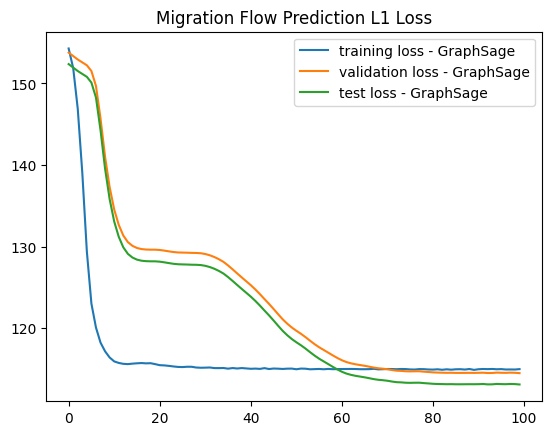

In [78]:
run_pipeline(args_GraphSage)